In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

from matplotlib.pyplot import figure
from tsfresh.utilities.dataframe_functions import impute
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from tsfresh import extract_features

import seaborn as sns
from fbprophet import Prophet
import matplotlib.patches as mpatches
from pylab import rcParams

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

import statsmodels.formula.api as smf
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from tqdm import tqdm

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

Parameters:

In [2]:
predictions = 24
integration_order = 1
season_integration_order = 1 
season_period = 24

CDFs:

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotMovingAverage(series, window, center=True, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        center - whether to center the window
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window, center=center).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    if plot_intervals:
        mae = mean_absolute_error(series[window:].fillna(0), rolling_mean[window:].fillna(0))
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax, style="-o")
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout() 
        
def timeseries_train_test_split(X, y, test_size):
   
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(8, 4))
    coefs.coef.plot(kind='bar')
    plt.title('Linear regression factors:')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    
def product(*args):
    if not args:
        return iter(((),)) 
    return (items + (item,) 
            for items in product(*args[:-1]) for item in args[-1])

def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        try:
            model=sm.tsa.statespace.SARIMAX(df.y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic

        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s+d] = np.NaN

    forecast = best_model.get_forecast(steps=50)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(8, 5))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True)
    
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
            
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(8, 5))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);            

Import data:

In [46]:
df = pd.read_csv('cluster/cpu.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.columns = ['ds', 'y']

print('Start:', str(df['ds'].iloc[1])[:10])
print('End:', str(df['ds'].iloc[-1])[:10])

df.set_index(keys='ds', inplace=True)
df.head()

Start: 2020-02-26
End: 2020-03-26


,y
ds,
2020-02-26 00:00:00,2400
2020-02-26 01:00:00,2430
2020-02-26 02:00:00,2518
2020-02-26 03:00:00,1015
2020-02-26 04:00:00,2480


Plot CPU load:

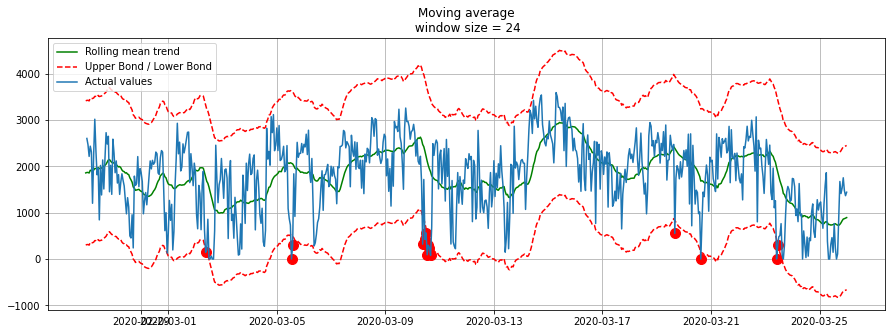

In [47]:
plotMovingAverage(df, 24, plot_intervals=True, center=False, scale=1.5, plot_anomalies=True)

ADF test:

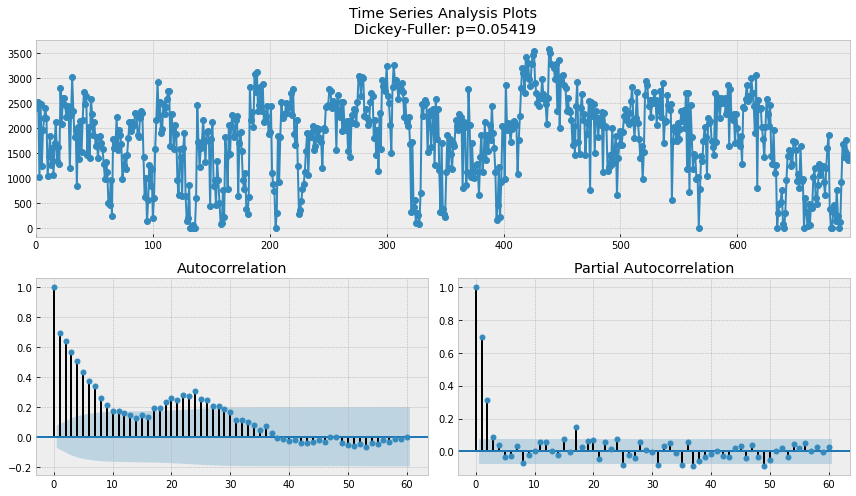

In [48]:
df.reset_index(inplace=True)
tsplot(df['y'], lags=60)

Cyclical adjusted time series (CATS):

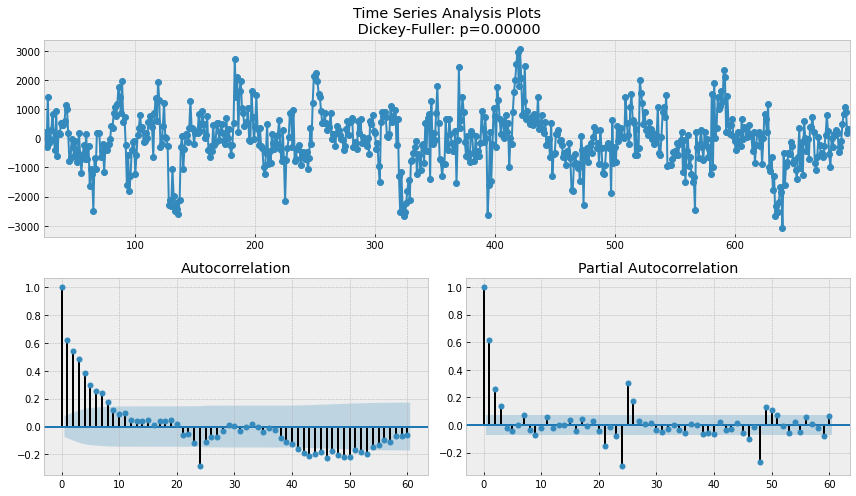

In [49]:
df_diff = df.copy()
df_diff['y'] = df['y'] - df['y'].shift(season_period)
df_diff.dropna(inplace=True)
tsplot(df_diff['y'], lags=60)

Normalize time series:

In [50]:
df['y'] = df['y'].apply(lambda x: (x - min(df['y'])))
df['y'] = df['y'].apply(lambda x: (x + 0.01*(max(df['y'])-min(df['y']))))

Baseline MAPE:

In [51]:
df['y-1'] = df['y'].shift(1)
df_diff.dropna(inplace=True)

error = mean_absolute_percentage_error(df['y'], df['y-1'])
print('Baseline MAPE:', int(error), '%')

Baseline MAPE: 61 %


Facebook Prophet decomposition:

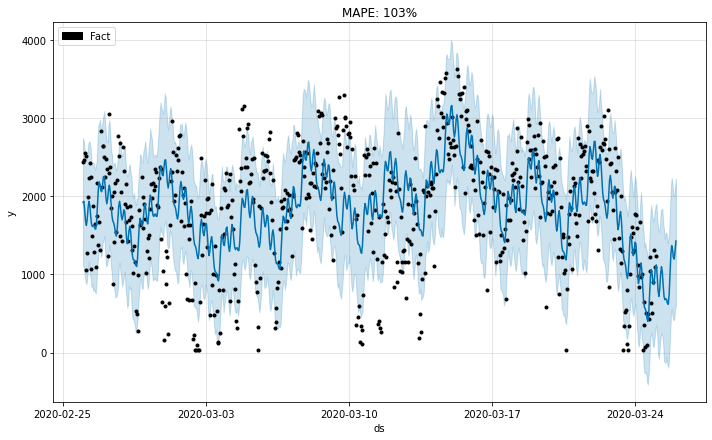

In [10]:
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative')
model.fit(df[:-predictions])
forecast = model.predict(model.make_future_dataframe(periods=predictions, freq='H'))

fig = model.plot(forecast)
black_patch = mpatches.Patch(color='black', label='Fact')
error = mean_absolute_percentage_error(df['y'], forecast['yhat'])

plt.legend(handles=[black_patch], loc="upper left")
plt.title('MAPE: '+str(int(error))+'%')
plt.show()

Show components of Facebook Prophet:

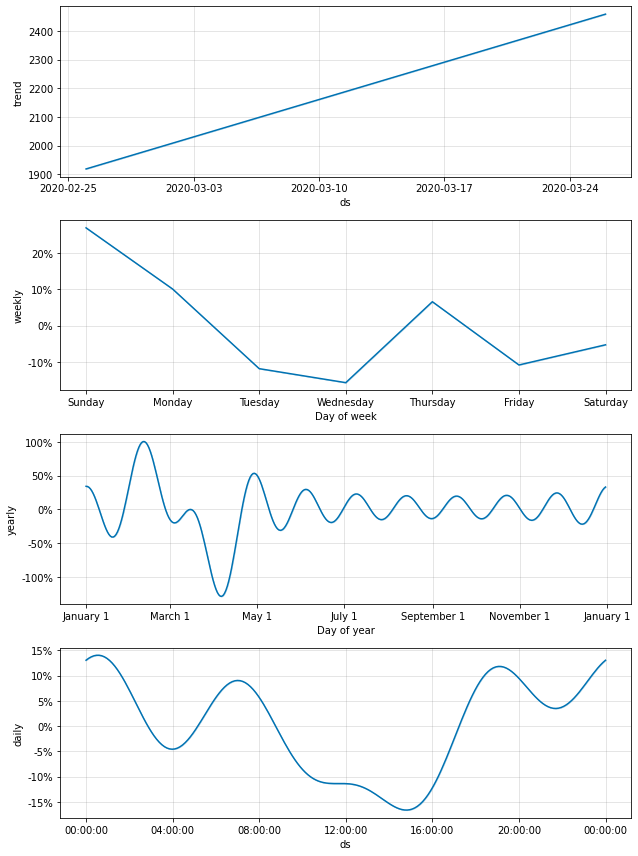

In [11]:
_ = model.plot_components(forecast)

Feature generation:

In [12]:
data = pd.DataFrame(df['y'].copy())
data.columns = ['y']

for i in range(1, 30):
    data["lag_{}".format(i)] = data.y.shift(i)

Correlation between features:

[]

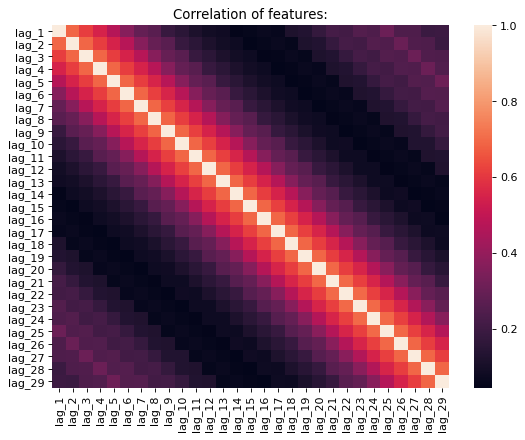

In [13]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(X_train.corr())
plt.title('Correlation of features:')
rcParams['figure.figsize'] = 5, 10
plt.plot()

Linear regression model:

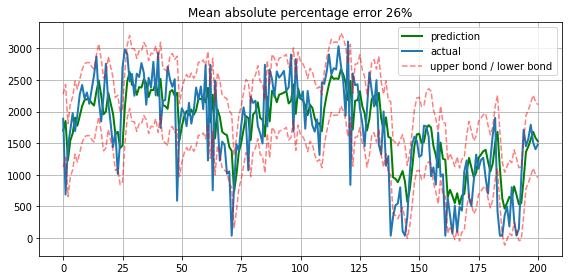

In [14]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(8, 4))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=TimeSeriesSplit(), 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.0f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

lasso = LassoCV(cv=TimeSeriesSplit(), eps=0.01)
lasso.fit(X_train, y_train)
plotModelResults(lasso, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=False)

Plot coefficients of TS memory:

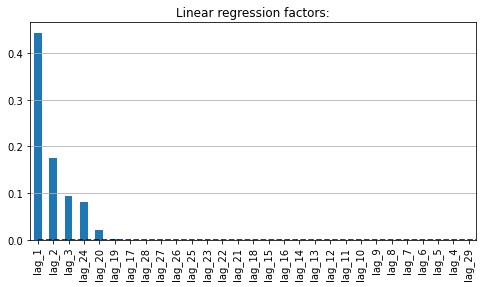

In [15]:
plotCoefficients(lasso)

Fit ARIMA model:

In [16]:
%%time
ps = range(2, 5)
qs = range(2, 10)
Ps = range(0, 2)
Qs = range(0, 2)

parameters_list = list(product(ps, qs, Ps, Qs))
result_table = optimizeSARIMA(parameters_list, integration_order, season_integration_order, season_period)

C:\Users\sakamen2\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\sakamen2\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\sakamen2\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\sakamen2\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\sakamen2\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\sakamen2\AppData\Local\Con

C:\Users\sakamen2\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\sakamen2\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\sakamen2\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\sakamen2\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\sakamen2\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\sakamen2\AppData\Local\Con


Wall time: 1h 4min 6s


Choose best model:

In [18]:
p, q, P, Q = result_table.parameters[0]
best_model=sm.tsa.statespace.SARIMAX(df['y'], order=(p, 1, q), seasonal_order=(P, 1, Q, 24)).fit(disp=-1)

Plot residuals:

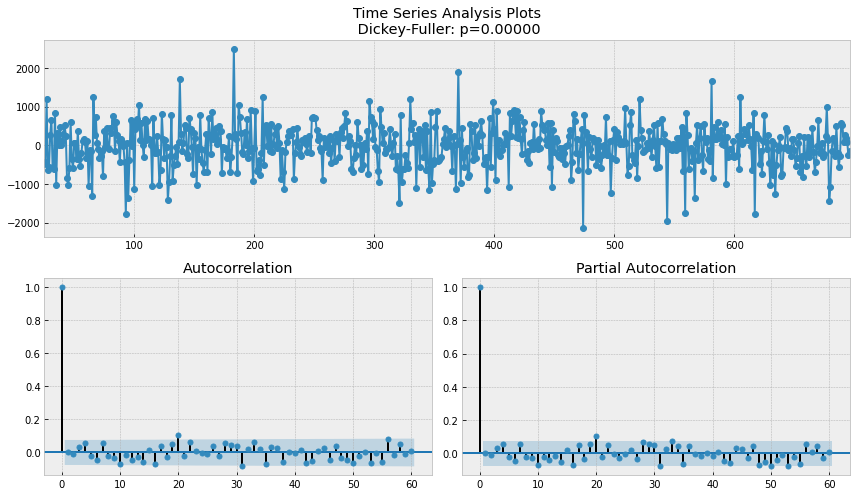

In [19]:
tsplot(best_model.resid[24+1:], lags=60)

Plot SARIMA forecast:

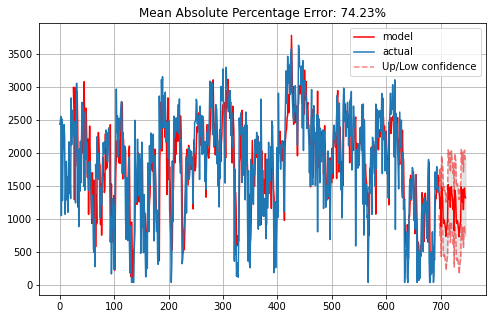

In [20]:
plotSARIMA(pd.DataFrame(df['y']), best_model, 50, alpha=0.5)

Holt - Winters model:

0.007539616995067611 0.00823702196239956 0.0
Wall time: 2.23 s


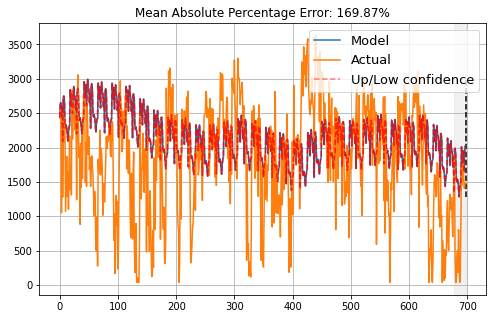

In [21]:
%%time
x = [0, 0, 0]
data = df['y'][:-20]
opt = minimize(timeseriesCVscore, x0=x, args=(data, mean_squared_error), method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = 24, alpha = alpha_final, beta = beta_final, 
gamma = gamma_final, n_preds = 20, scaling_factor = 2)

model.triple_exponential_smoothing()
plotHoltWinters(df['y'], plot_intervals=True, plot_anomalies=False)

Gradient Boosting:

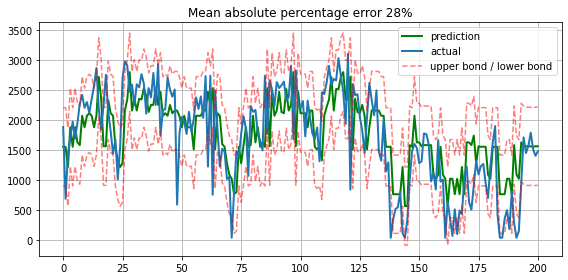

In [22]:
gbr = AdaBoostRegressor(n_estimators=10, loss='square')
gbr.fit(X_train, y_train)
plotModelResults(gbr, X_train=X_train, X_test=X_test, plot_intervals=True, plot_anomalies=False)

TS fresh - extract features:

In [23]:
df_shift, y = make_forecasting_frame(df['y'], kind='load', max_timeshift=24, rolling_direction=1)
X = extract_features(df_shift, column_id='id', column_sort='time', column_value='value', impute_function=impute)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]


TS fresh - fit/predict:

In [24]:
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

isp = 50  
assert isp > 0

for i in tqdm(range(isp, len(y))):
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

100%|████████████████████████████████████████████████████████████████████████████████| 646/646 [02:23<00:00,  4.49it/s]


Plot predicted and actual:

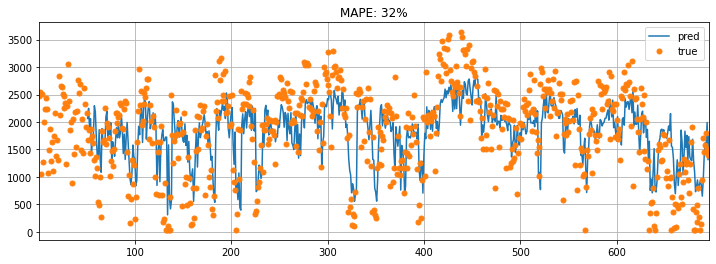

In [25]:
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})
error = mean_absolute_percentage_error(ys['pred'], ys['true'])

ys['pred'].plot(figsize=(12, 4), markersize=5, style='-', legend=True)
ys['true'].plot(figsize=(12, 4), markersize=5, style='o', legend=True)
plt.grid()

plt.title('MAPE: '+str(int(error))+'%')
plt.show()

Distribution along hours:

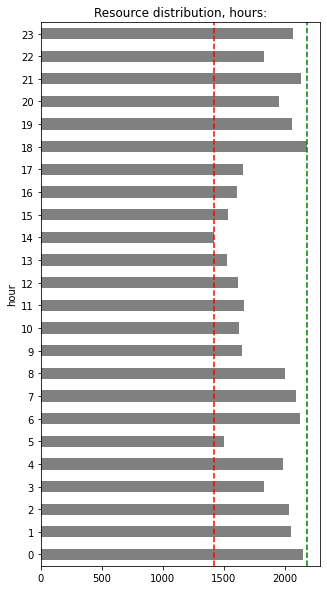

In [52]:
df['ds'] = pd.to_datetime(df['ds'])
df.dropna(inplace=True)
df['hour'] = df['ds'].dt.hour

df_class = df[['hour', 'y']].groupby('hour', as_index = True).mean()
df_class['y'].plot.barh(color='gray')
plt.axvline(x = min(df_class['y']), color='red', linestyle='--')
plt.axvline(x = max(df_class['y']), color='green', linestyle='--')

plt.title('Resource distribution, hours:')
plt.show()

Distribution among days:

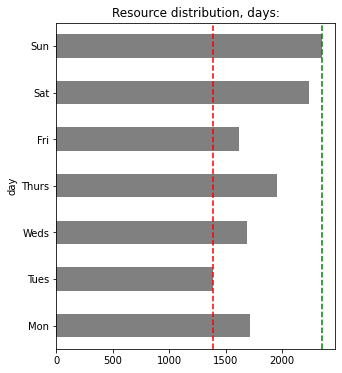

In [67]:
df['day'] = df['ds'].dt.dayofweek
day_of_week = {0: 'Mon', 1: 'Tues', 2: 'Weds', 3: 'Thurs', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df.replace({'day': day_of_week}, inplace=True)

df_class = df[['day', 'y']].groupby('day', as_index = True).mean()
df_class = df_class.reindex(['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat','Sun'])

df_class['y'].plot.barh(color='gray', figsize=(5,6))
plt.axvline(x = min(df_class['y']), color='red', linestyle='--')
plt.axvline(x = max(df_class['y']), color='green', linestyle='--')

plt.title('Resource distribution, days:')
plt.show()